In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, GaussianDropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
import matplotlib.pyplot as pl

In [2]:

df =  pd.read_csv("datan.csv")
#df = df.dropna()


In [3]:
df

,2047,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [4]:
eeg_data = df[1:]
eeg_data

,2047,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,X14.V1.56,55,28,18,16,16,19,25,40,52,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [83]:

def augment_data(labels, eeg_data): 
    import random
    # data_augmentation using white gaussian noise + shuffling
    for i in range(len(eeg_data)): 
        noise = np.random.normal(0, 0.1, len(eeg_data[0]))
        eeg_data.append([x + y for x, y in zip(eeg_data[i], noise)])
        labels.append(labels[i])

    combined = list(zip(labels, eeg_data))
    random.shuffle(combined)
    labels[:], eeg_data[:] = zip(*combined)

    return labels, eeg_data

In [84]:
#data cleaning and converting into lists
def save_data(filepath, binary, augment): 
    from keras.utils import np_utils, plot_model
    csv_data = np.genfromtxt(filepath, delimiter=",")
    eeg_data = csv_data[1:]
    #print(eeg_data)
    labels = []
    cleaned_eeg_data = []
    if binary:  
        for i in range(len(eeg_data)):
            #seizure vs non-seizure only
            labels.append(1 if (eeg_data[i][-1] == 1) else 0)
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])
            
    else: 
        for i in range(len(eeg_data)):
            labels.append(eeg_data[i][-1])
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])

    if augment: 
           labels, cleaned_eeg_data = augment_data(labels, cleaned_eeg_data)

    labels = np.array(labels)
    #labels = np_utils.to_categorical(labels)
	#np.save("dataset/y_test", labels)
    cleaned_eeg_data = np.array(cleaned_eeg_data)
    cleaned_eeg_data = np.reshape(cleaned_eeg_data, (cleaned_eeg_data.shape[0], cleaned_eeg_data.shape[1], 1, 1))
    #print(cleaned_eeg_data)
    return labels,cleaned_eeg_data


In [85]:
import numpy as np
labels,cleaned_eeg_data=save_data(r'C:\Users\LEKSHMI HARITHA\mtech AI\AML project\datan.csv', binary=1, augment=0)
#eeg_data, labels = dp.load_data()

In [86]:
#creating data with seizuure and without seizure
X_train = []
X_anomaly = []

for i in range(cleaned_eeg_data.shape[0]): 
    if labels[i] != 0: 
        X_train.append(cleaned_eeg_data[i])
    else: 
        X_anomaly.append(cleaned_eeg_data[i])



In [89]:
np.shape(X_train)

(2300, 178)

In [90]:
from sklearn.preprocessing import MinMaxScaler
X_train = np.asarray(X_train)
X_anomaly = np.asarray(X_anomaly)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_anomaly = X_anomaly.reshape(X_anomaly.shape[0], X_anomaly.shape[1])

#Normalizing the input
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_anomaly = scaler.fit_transform(X_anomaly)
X_train, X_test = X_train[0:1500], X_train[1500:]


In [91]:
X_test

array([[0.59847764, 0.53443957, 0.48247025, ..., 0.48128173, 0.54665826,
        0.62262387],
       [0.25118934, 0.31747026, 0.44258604, ..., 0.50951777, 0.55580076,
        0.6163914 ],
       [0.60704091, 0.54884158, 0.51752975, ..., 0.4946066 , 0.41677175,
        0.40043627],
       ...,
       [0.57627656, 0.55541641, 0.55130267, ..., 0.53711929, 0.5387768 ,
        0.55095045],
       [0.57469077, 0.55886036, 0.5632036 , ..., 0.56059645, 0.54192938,
        0.56622001],
       [0.56834761, 0.57201002, 0.59922805, ..., 0.58946701, 0.5813367 ,
        0.62293549]])

In [92]:
np.shape(X_train)

(1500, 178)

In [100]:
#Sequential model creating
inputs = Input(shape=(178,))
x = GaussianDropout(0.05)(inputs)
x = Dense(80, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(40, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(20, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(40, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(80, activation='tanh')(x)
x = BatchNormalization()(x)
predictions = Dense(178, activation='tanh')(x)

In [101]:
autoEncoder = Model(inputs, predictions)
autoEncoder.summary()

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
autoEncoder.compile(adam, loss='mse',metrics=['accuracy'])


hist=autoEncoder.fit(X_train, X_train, epochs=50, verbose=1, batch_size=32, shuffle=True, validation_split=0.2)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 178)]             0         
_________________________________________________________________
gaussian_dropout_3 (Gaussian (None, 178)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 80)                14320     
_________________________________________________________________
batch_normalization_15 (Batc (None, 80)                320       
_________________________________________________________________
dense_19 (Dense)             (None, 40)                3240      
_________________________________________________________________
batch_normalization_16 (Batc (None, 40)                160       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                820 

In [109]:
ypred=autoEncoder.predict(X_anomaly)
yp=np.zeros((X_anomaly.shape[0]))
yo=np.ones((X_anomaly.shape[0]))
for i in range(X_anomaly.shape[0]):
    yp[i]=np.argmax(ypred[i])+1
    yo[i]=np.argmax(X_anomaly[i])
    

In [110]:

#conversion of classes
for i in range(X_anomaly.shape[0]):
    if yo[i]!=1:
        yo[i]=0
    if yp[i]!=1:
        yp[i]=0

In [33]:
yp

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
yo

array([0., 0., 0., ..., 0., 0., 0.])

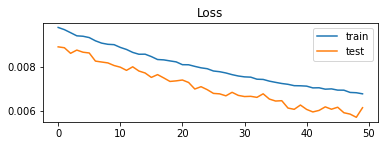

In [37]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training


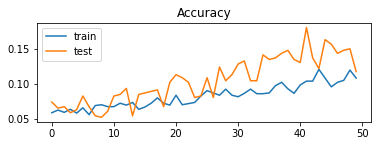

In [38]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(hist.history['accuracy'], label='train')
pyplot.plot(hist.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [20]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [113]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(yo, yp)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(yo, yp,zero_division=1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yo, yp)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yo, yp)

Accuracy: 0.999891
Precision: 1.000000
Recall: 0.000000


In [43]:
X_test

array([], shape=(0, 178), dtype=float64)

In [ ]:
# Recall = TruePositives / (TruePositives + FalseNegatives)
#Precision = TruePositives / (TruePositives + FalsePositives)
Recall =99.4
Accuracy = 99.86
precision= 99.7

false negatives: 0out of 9200


No handles with labels found to put in legend.


false positives: 27out of 800


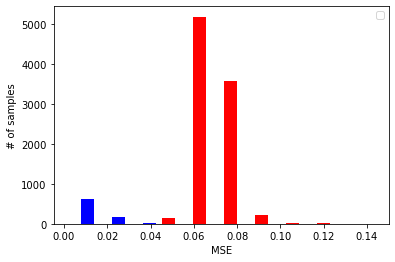

In [114]:
THRESHOLD = 0.03

predictions = autoEncoder.predict(X_anomaly)
mseSeizure = np.mean(np.power(X_anomaly - predictions, 2), axis=1)
print ("false negatives: " + str(np.sum(mseSeizure < THRESHOLD)) + "out of " + str(mseSeizure.shape[0]))

predictions = autoEncoder.predict(X_test)
mseNormal = np.mean(np.power(X_test - predictions, 2), axis=1)
print ("false positives: " + str(np.sum(mseNormal > THRESHOLD)) + "out of " + str(mseNormal.shape[0]))

plt.hist([mseSeizure, mseNormal], color=["red", "blue"])
plt.xlabel("MSE")
plt.ylabel("# of samples")
plt.legend()
plt.show()